In [1]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
from io_data import loadSpatialDataset
from analyze import calcUmap, plotUmap
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import random
from tqdm import tqdm

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

In [3]:
def initializeAdata(data_path = "/media/gambino/students_workdir/nynke/blurry_model/ileum_data/mouse_ileum/coordinate_parsed/*.tif", adata_concat='blurry'):
    adata = loadSpatialDataset(single_gene_images_glob = data_path, adata_to_concat=adata_concat)
    img_paths = adata.obs["original_image_paths"]
    cell_ids = [re.findall('icell(\d+)', img_path)[0] for img_path in img_paths]
    adata.obs['cell_id'] = cell_ids
    return adata

In [ ]:
# removing the biological real data from the similated data
#adata_bio = adata
#adata = adata[adata.obs['pattern']!='spatial']
#adata.obs.reset_index(drop=True, inplace=True)

In [5]:
adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")

In [6]:
adata.obs['train_or_val'].value_counts()

train    433925
val      108482
Name: train_or_val, dtype: int64

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


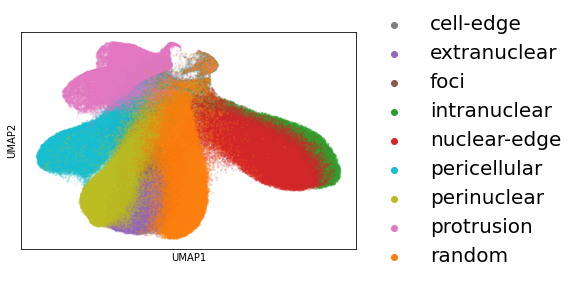

In [30]:
calcUmap(adata)
plotUmap(adata, "pattern", pattern_to_alpha = "spatial")

In [3]:
adata = loadSpatialDataset(single_gene_images_glob = "/media/gambino/students_workdir/nynke/blurry_model/ileum_data/mouse_ileum/coordinate_parsed/*.tif", adata_to_concat="blurry")

Loading images: 100%|██████████| 3514/3514 [02:23<00:00, 24.45image/s]


<class 'io_data.ImageDatasetWithDapis'>


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass 

## Dealing with cell_id and spatial data

In [4]:
# removing the biological real data from the similated data
adata_bio = adata
adata = adata[adata.obs['pattern']!='spatial']
adata.obs.reset_index(drop=True, inplace=True)
adata.obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,blur_interval,...,pattern_classified,cell-edge,extranuclear,intranuclear,pericellular,perinuclear,random,random_score,pattern_score,batch
0,cell-edge,pattern,100,100+,blank,blank,124,120-180,1.5,NaN,...,random,9.985172e-01,0.422161,2.038958e-18,8.139958e-18,1.522162e-11,0.999980,0.806723,0.193872,0
1,cell-edge,pattern,100,100+,blank,blank,161,120-180,1.5,NaN,...,random,9.996459e-01,0.938447,9.300263e-20,9.723175e-17,1.278433e-09,0.999978,0.786449,0.214457,0
2,cell-edge,pattern,100,100+,blank,blank,57,0-60,1.5,NaN,...,random,9.929121e-01,0.868868,2.720590e-19,1.327658e-16,1.400917e-09,0.997670,0.613716,0.387979,0
3,cell-edge,pattern,100,100+,blank,blank,96,60-120,1.5,NaN,...,random,9.974719e-01,0.683816,2.393022e-18,1.593811e-17,2.160465e-10,0.999952,0.816660,0.184197,0
4,cell-edge,pattern,100,100+,blank,blank,245,240-300,1.5,NaN,...,cell-edge,9.991395e-01,0.997390,2.491777e-19,1.006105e-10,3.958879e-08,0.007829,0.058782,0.941308,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220682,random,random,99,100+,blank,blank,193,180-240,1.5,NaN,...,random,2.101227e-05,0.004966,9.210425e-13,2.441267e-30,3.942036e-05,1.000000,0.999117,0.000895,0
220683,random,random,99,100+,blank,blank,196,180-240,1.5,NaN,...,random,1.683812e-07,0.002076,2.011644e-14,6.885430e-33,5.124744e-05,1.000000,0.998786,0.001229,0
220684,random,random,99,100+,blank,blank,247,240-300,1.5,NaN,...,random,3.827430e-04,0.000675,6.427072e-12,2.209788e-29,3.792834e-07,1.000000,0.998853,0.001155,0
220685,random,random,99,100+,blank,blank,302,300+,1.5,NaN,...,random,1.809081e-08,0.000406,4.297435e-13,2.204371e-32,2.143221e-03,1.000000,0.998953,0.001053,0


In [5]:
import re
img_paths = adata.obs["original_image_paths"]
cell_ids = [re.findall('icell(\d+)', img_path)[0] for img_path in img_paths]
from collections import Counter
Counter(cell_ids)

Counter({'149': 709,
         '272': 683,
         '52': 680,
         '75': 728,
         '142': 649,
         '313': 707,
         '162': 667,
         '225': 707,
         '42': 683,
         '15': 698,
         '170': 699,
         '238': 701,
         '252': 673,
         '103': 708,
         '24': 709,
         '257': 706,
         '4': 688,
         '265': 715,
         '213': 694,
         '244': 710,
         '297': 724,
         '113': 702,
         '20': 717,
         '249': 701,
         '31': 676,
         '59': 680,
         '134': 719,
         '135': 695,
         '155': 691,
         '43': 705,
         '7': 656,
         '124': 688,
         '290': 698,
         '6': 702,
         '171': 695,
         '191': 700,
         '232': 701,
         '9': 732,
         '217': 707,
         '35': 706,
         '100': 695,
         '118': 689,
         '127': 707,
         '165': 720,
         '208': 665,
         '261': 687,
         '0': 689,
         '175': 718,
         '23

In [6]:
adata.obs['cell_id'] = cell_ids
adata.obs

<ipython-input-6-7ad4a476ae2a>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_id'] = cell_ids
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,blur_interval,...,pattern_classified,cell-edge,extranuclear,intranuclear,pericellular,perinuclear,random,random_score,pattern_score,batch
0,cell-edge,pattern,100,100+,149,blank,124,120-180,1.5,NaN,...,random,9.985172e-01,0.422161,2.038958e-18,8.139958e-18,1.522162e-11,0.999980,0.806723,0.193872,0
1,cell-edge,pattern,100,100+,149,blank,161,120-180,1.5,NaN,...,random,9.996459e-01,0.938447,9.300263e-20,9.723175e-17,1.278433e-09,0.999978,0.786449,0.214457,0
2,cell-edge,pattern,100,100+,149,blank,57,0-60,1.5,NaN,...,random,9.929121e-01,0.868868,2.720590e-19,1.327658e-16,1.400917e-09,0.997670,0.613716,0.387979,0
3,cell-edge,pattern,100,100+,149,blank,96,60-120,1.5,NaN,...,random,9.974719e-01,0.683816,2.393022e-18,1.593811e-17,2.160465e-10,0.999952,0.816660,0.184197,0
4,cell-edge,pattern,100,100+,272,blank,245,240-300,1.5,NaN,...,cell-edge,9.991395e-01,0.997390,2.491777e-19,1.006105e-10,3.958879e-08,0.007829,0.058782,0.941308,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220682,random,random,99,100+,80,blank,193,180-240,1.5,NaN,...,random,2.101227e-05,0.004966,9.210425e-13,2.441267e-30,3.942036e-05,1.000000,0.999117,0.000895,0
220683,random,random,99,100+,80,blank,196,180-240,1.5,NaN,...,random,1.683812e-07,0.002076,2.011644e-14,6.885430e-33,5.124744e-05,1.000000,0.998786,0.001229,0
220684,random,random,99,100+,80,blank,247,240-300,1.5,NaN,...,random,3.827430e-04,0.000675,6.427072e-12,2.209788e-29,3.792834e-07,1.000000,0.998853,0.001155,0
220685,random,random,99,100+,80,blank,302,300+,1.5,NaN,...,random,1.809081e-08,0.000406,4.297435e-13,2.204371e-32,2.143221e-03,1.000000,0.998953,0.001053,0


### Split in train val test - Without splitting per cell_id.

In [ ]:
# use a 80-10-10 split
def train_val_test(adata, seed: str = seed, split_per_cellID: bool = True):
    all_indices = adata.obs.index

    if split_per_cellID == True:
        cell_ids = np.array(adata.obs['cell_id'])
        unique_cell_ids, cell_id_indices = np.unique(cell_ids, return_inverse=True)

        # Perform train-val-test split on cell_ids, maintaining the grouping
        train_indices, test_val_indices = skm.train_test_split(np.arange(len(unique_cell_ids)), test_size=0.2, random_state=seed)
        val_indices, test_indices = skm.train_test_split(test_val_indices, test_size=0.5, random_state=seed)

        # Map the grouped indices back to the original indices
        train_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in train_indices])
        val_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in val_indices])
        test_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in test_indices])
    else:
        train_indices, test_val_indices = skm.train_test_split(all_indices, test_size=0.2, random_state=seed)
        val_indices, test_indices = skm.train_test_split(test_val_indices, test_size=0.5, random_state=seed)

    # Subset AnnData object using the obtained indices
    adata_train = adata[train_indices, :]
    adata_val = adata[val_indices, :]
    adata_test = adata[test_indices, :]

    return adata_train, adata_val, adata_test

In [7]:
# Step 1: Get the indices of the observations
all_indices = adata.obs.index

# Step 2: Perform train-val-test split on indices. Total split is 80-10-10
train_indices, test_indices = skm.train_test_split(all_indices, test_size=0.1, random_state=seed)
train_indices, val_indices = skm.train_test_split(train_indices, test_size=1/9, random_state=seed)

# Step 3: Subset AnnData object using the obtained indices
adata_train = adata[train_indices, :] # 179360 x 15
adata_val = adata[val_indices, :]     # 22420  x 15
adata_test = adata[test_indices, :]   # 22421  x 15
# total adata object:                   224201 x 15

Max features for the random forest at first will be put to sqrt(15) ~3. Based on validation will see whether want to change that to 4. 
* `n_estimators`: number of trees. According to scikit-learn, the larger the better, but does take longer to compute and at some point it doesn't really explain much extra variance. 
* `max_features`: size of random subset of features to consider when splitting a node. The lower: the greater reduction in variance, but the higher increase in bias. Empirical good default values: max_features=”sqrt” (according to [scikit-learn](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters))
    * Do parameter search [2,3,4,5], because sqrt(15)~3.87, so we choose 2,3,4,5 as values around that. 
* `max_leaf_nodes`: maximum number of leafs at the bottom of the tree. 
    * Included to reduce memory consumption, as the default settings for controlling the tree size will result in fully grown and unpruned trees.
    * Max leaf nodes is chosen rather than max_depth, to allow for assymetrical trees.
* By default, bootstramp samples are used. When using bootstrap sampling, the generalization error can be estimated on the left out (or out-of-bag) samples. You can enable this with setting `oob_score=True`

In [8]:
# Create a random forest classifier.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=seed, max_features='sqrt', bootstrap=True, oob_score=True)
rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

RandomForestClassifier(oob_score=True, random_state=101)

In [9]:
#out of bag score during training
rf_classifier.oob_score_

0.9263603872012869

In [10]:
#out of bag score during training
rf_classifier.oob_score_

0.9263603872012869

In [11]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV

In [12]:
adata_train_labels = adata_train.copy()
pattern_mapping = {'pattern': 1, 'random': 0}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

The code below did a GridSearchCV. However, because of the large gridsearch space, it was too time consuming and was stopped. Instead we will use halvingGridSearchCV

In [27]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(random_state=seed, bootstrap=True, oob_score=True, n_estimators=100)
param_grid = {'max_features': [2,3,4,5,6]}

grid_search = GridSearchCV(base_forest, param_grid=param_grid, scoring='f1', verbose=3, error_score='raise')
grid_search.fit(latent,labels)

print(grid_search.cv_results_)
print("Best parameters: ")
print(grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....................max_features=2;, score=0.949 total time=  25.8s
[CV 2/5] END ....................max_features=2;, score=0.949 total time=  25.9s
[CV 3/5] END ....................max_features=2;, score=0.948 total time=  25.9s
[CV 4/5] END ....................max_features=2;, score=0.950 total time=  25.8s
[CV 5/5] END ....................max_features=2;, score=0.949 total time=  25.9s
[CV 1/5] END ....................max_features=3;, score=0.949 total time=  36.4s
[CV 2/5] END ....................max_features=3;, score=0.949 total time=  36.6s
[CV 3/5] END ....................max_features=3;, score=0.949 total time=  36.5s
[CV 4/5] END ....................max_features=3;, score=0.950 total time=  36.5s
[CV 5/5] END ....................max_features=3;, score=0.949 total time=  36.6s
[CV 1/5] END ....................max_features=4;, score=0.949 total time=  47.5s
[CV 2/5] END ....................max_features=4;,

TypeError: can only concatenate str (not "dict") to str

In [23]:
grid_search.cv_results_

{'mean_fit_time': array([25.36191697, 36.09720526, 46.96839042, 58.87501168, 69.62363806]),
 'std_fit_time': array([0.12504424, 0.03820943, 0.1886689 , 0.56897949, 0.23001813]),
 'mean_score_time': array([0.38908339, 0.37095618, 0.35829029, 0.35844798, 0.34856634]),
 'std_score_time': array([0.00109477, 0.00150513, 0.00235228, 0.0047632 , 0.00223408]),
 'param_max_features': masked_array(data=[2, 3, 4, 5, 6],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_features': 2},
  {'max_features': 3},
  {'max_features': 4},
  {'max_features': 5},
  {'max_features': 6}],
 'split0_test_score': array([0.94858907, 0.94909818, 0.94860877, 0.9487545 , 0.94826322]),
 'split1_test_score': array([0.94866717, 0.94920358, 0.94937562, 0.94908528, 0.94861927]),
 'split2_test_score': array([0.9483518 , 0.94931678, 0.94875346, 0.94853683, 0.9485038 ]),
 'split3_test_score': array([0.94952887, 0.95005238, 0.94906209, 0.94955806, 0.9

Now that we have found the optimal parameters for `max_features`, we will look at which value should be chosen for the `n_estimators`

In [15]:
train_accuracy = []
val_accuracy = []
for count in tqdm(range(50, 501, 50)):
    # create random forest classifier and fit on training data
    rf_classifier = RandomForestClassifier(n_estimators=count, random_state=seed, max_features=4, bootstrap=True, oob_score=True)
    rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 
    
    #predict label
    train_pred = rf_classifier.predict(adata_train.obsm["latent"])
    val_pred = rf_classifier.predict(adata_val.obsm["latent"])

    # Obtain training and validation F1 score. 
    train_f1 = f1_score(adata_train.obs["random_or_pattern"], train_pred, pos_label='pattern')
    val_f1 = f1_score(adata_val.obs["random_or_pattern"], val_pred, pos_label='pattern')

    #append scores to lists
    train_accuracy.append(train_f1)
    val_accuracy.append(val_f1)

  0%|          | 0/10 [00:00<?, ?it/s]100%|██████████| 10/10 [29:38<00:00, 177.85s/it]


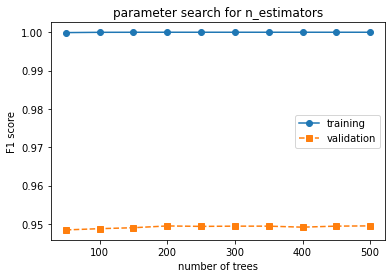

In [16]:
plt.figure()

x_values = range(50, 501, 50)

plt.plot(x_values, train_accuracy, label='training', linestyle='-', marker='o')
plt.plot(x_values, val_accuracy, label='validation', linestyle='--', marker='s')

# Add labels and legend
plt.title('parameter search for n_estimators')
plt.xlabel('number of trees')
plt.ylabel('F1 score')
plt.legend()
plt.show()

There doesn't seem to be a large difference in performance between the different number of trees. 200 trees seems to give a slightly higher validation than the rest, so we will pick that. 

*Check whether performance difference can be attributed to* cell identity difference, if not it seems to be influenced by max tree depth. 

In [ ]:
confusion_matrix = metrics.confusion_matrix(adata_val.obs["pattern"], val_pred, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

## Train val test split Based on cell_ids

In [8]:
# Step 1: Group indices by cell_id
all_indices = adata.obs.index
cell_ids = np.array(adata.obs['cell_id'])
unique_cell_ids, cell_id_indices = np.unique(cell_ids, return_inverse=True)

In [9]:
# Step 1: Group indices by cell_id
all_indices = adata.obs.index
cell_ids = np.array(adata.obs['cell_id'])
unique_cell_ids, cell_id_indices = np.unique(cell_ids, return_inverse=True)

# Step 3: Perform train-val-test split on cell_ids, maintaining the grouping
train_indices, test_val_indices = skm.train_test_split(np.arange(len(unique_cell_ids)), test_size=0.2, random_state=seed)
val_indices, test_indices = skm.train_test_split(test_val_indices, test_size=0.5, random_state=seed)

# Step 4: Map the grouped indices back to the original indices
train_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in train_indices])
val_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in val_indices])
test_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in test_indices])

# Step 5: Subset AnnData object using the obtained indices
adata_train = adata[train_indices, :] # Training set:   176162 x 15
adata_val = adata[val_indices, :]     # Validation set: 22269 x 15
adata_test = adata[test_indices, :]   # Test set:       22256 x 15

Check if there indeed is no overlap in cell_id between the train-val-test groups

In [10]:
print(set(adata_train.obs['cell_id']).intersection(adata_val.obs['cell_id'], adata_test.obs['cell_id']))
set(adata_train.obs['cell_id']) & set(adata_val.obs['cell_id'])

set()


set()

# Random Forest

## Pattern / no pattern

In [11]:
# Create a random forest classifier.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=seed, max_features='sqrt', bootstrap=True, oob_score=True)
rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

#out of bag score during training
rf_classifier.oob_score_

0.9615854448536897

In [ ]:
# Create a random forest classifier.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=seed, max_features='sqrt', bootstrap=True, oob_score=True)
rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

#out of bag score during training
rf_classifier.oob_score_

0.9267946549199033

In [27]:
adata_train_labels = adata_train.copy()
pattern_mapping = {'pattern': 1, 'random': 0}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [30]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(random_state=seed, bootstrap=True, oob_score=True, n_estimators=100)
param_grid = {'max_features': [2,3,4,5,6]}

grid_search = GridSearchCV(base_forest, param_grid=param_grid, scoring='f1', verbose=3, error_score='raise')
grid_search.fit(latent,labels)

print(grid_search.cv_results_)
print("Best parameters: ")
print(grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....................max_features=2;, score=0.948 total time=  25.6s
[CV 2/5] END ....................max_features=2;, score=0.950 total time=  25.4s
[CV 3/5] END ....................max_features=2;, score=0.946 total time=  25.4s
[CV 4/5] END ....................max_features=2;, score=0.945 total time=  25.2s
[CV 5/5] END ....................max_features=2;, score=0.950 total time=  25.3s
[CV 1/5] END ....................max_features=3;, score=0.948 total time=  36.1s
[CV 2/5] END ....................max_features=3;, score=0.950 total time=  35.9s
[CV 3/5] END ....................max_features=3;, score=0.946 total time=  35.7s
[CV 4/5] END ....................max_features=3;, score=0.945 total time=  35.7s
[CV 5/5] END ....................max_features=3;, score=0.950 total time=  35.7s
[CV 1/5] END ....................max_features=4;, score=0.949 total time=  46.9s
[CV 2/5] END ....................max_features=4;,

In [32]:
train_accuracy = []
val_accuracy = []
for count in tqdm(range(50, 501, 50)):
    # create random forest classifier and fit on training data
    rf_classifier = RandomForestClassifier(n_estimators=count, random_state=seed, max_features=4, bootstrap=True, oob_score=True)
    rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 
    
    #predict label
    train_pred = rf_classifier.predict(adata_train.obsm["latent"])
    val_pred = rf_classifier.predict(adata_val.obsm["latent"])

    # Obtain training and validation F1 score. 
    train_f1 = f1_score(adata_train.obs["random_or_pattern"], train_pred, pos_label='pattern')
    val_f1 = f1_score(adata_val.obs["random_or_pattern"], val_pred, pos_label='pattern')

    #append scores to lists
    train_accuracy.append(train_f1)
    val_accuracy.append(val_f1)

100%|██████████| 10/10 [29:01<00:00, 174.14s/it]


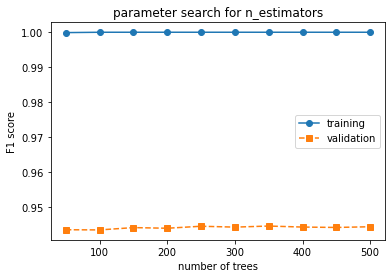

In [33]:
plt.figure()

x_values = range(50, 501, 50)

plt.plot(x_values, train_accuracy, label='training', linestyle='-', marker='o')
plt.plot(x_values, val_accuracy, label='validation', linestyle='--', marker='s')

# Add labels and legend
plt.title('parameter search for n_estimators')
plt.xlabel('number of trees')
plt.ylabel('F1 score')
plt.legend()
plt.show()

In [35]:
val_accuracy

[0.94358651118815,
 0.9435366853826257,
 0.944197343932368,
 0.9440151395678916,
 0.9445863689406125,
 0.944335752603345,
 0.9446424628584046,
 0.944353312302839,
 0.9442393259490675,
 0.9444426917373884]

There is hardly any improvement with more trees in the random forest, stays at 94.5%.

In [11]:
 # create random forest classifier and fit on training data
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=4, bootstrap=True, oob_score=False)
rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 
    
#predict label
val_pred = rf_classifier.predict(adata_val.obsm["latent"])

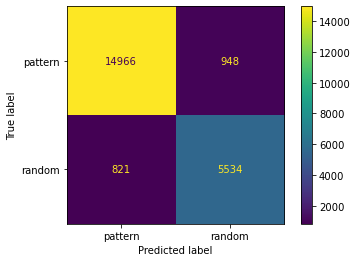

In [18]:
confusion_matrix = metrics.confusion_matrix(adata_val.obs["random_or_pattern"], val_pred, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

See the ratio of pattern/non pattern that the RF classifies the real biological data

In [18]:
bio_pred = rf_classifier.predict(adata_bio[adata_bio.obs['pattern']=='spatial'].obsm["latent"])
np.unique(bio_pred, return_counts=True)

(array(['pattern', 'random'], dtype=object), array([2956,  558]))

## Random Forest Multilabel

run the random forest for optimal parameters and get F1 score.
select only the pattern ones, and then do random forest on the pattern labels. 
In the end wanna do a for loop to combine the combinations between the different ones. random forest + other stuff etc. 

In [26]:
adata_val.obs['pattern']

1007      cell-edge
1008      cell-edge
1009      cell-edge
1010      cell-edge
1011      cell-edge
            ...    
541509       random
541510       random
541511       random
541512       random
541513       random
Name: pattern, Length: 54495, dtype: category
Categories (9, object): ['cell-edge', 'extranuclear', 'foci', 'intranuclear', ..., 'pericellular', 'perinuclear', 'protrusion', 'random']

In [27]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_val_pattern = adata_val.copy()
adata_val_pattern = adata_val_pattern[adata_val_pattern.obs['pattern']!='random']
#pattern_mapping = {'pattern': 1, 'random': 0}
#adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [21]:
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=4, bootstrap=True, oob_score=False)
rf_classifier.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

#predict label
val_pred = rf_classifier.predict(adata_val_pattern.obsm["latent"])


In [70]:
val_f1_macro = f1_score(adata_val_pattern.obs["pattern"], val_pred, average='macro')
val_f1_micro = f1_score(adata_val_pattern.obs["pattern"], val_pred, average='micro')
print('f1 validation: macro average:')
print(val_f1_macro)
print('f1 validation: micro average:')
print(val_f1_micro)

f1 validation: macro average:
0.826966474650541
f1 validation: micro average:
0.8282644212642954


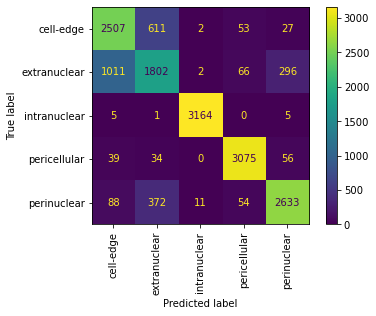

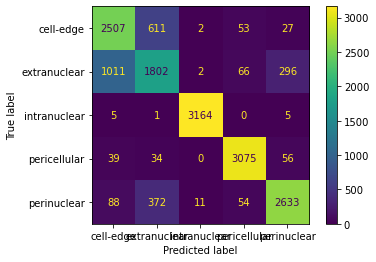

In [66]:
#confusion_matrix = metrics.confusion_matrix(adata_val_pattern.obs["pattern"], val_pred, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_true=adata_val_pattern.obs["pattern"], y_pred=val_pred, display_labels = rf_classifier.classes_, xticks_rotation='vertical') 
cm_display.plot()

In [22]:
bio_pred = rf_classifier.predict(adata_bio[adata_bio.obs['pattern']=='spatial'].obsm["latent"])
np.unique(bio_pred, return_counts=True)

(array(['cell-edge', 'extranuclear', 'intranuclear', 'pericellular',
        'perinuclear'], dtype=object),
 array([1435,  488,  679,  678,  234]))

Classifier score for pattern classifier that has mixed cell_id's. 

In [26]:
#out of bag score during training
rf_classifier.oob_score_

0.8450290080207971

## Random Forest - Separate Binary classifiers

In [20]:
adata_train_pattern = adata_train.copy()
adata_train_pattern.obs["extranuclear"] = np.where(adata_train_pattern.obs["pattern"] == "extranuclear", "extranuclear", "other")
adata_val_pattern = adata_val.copy()
adata_val_pattern.obs["extranuclear"] = np.where(adata_val_pattern.obs["pattern"] == "extranuclear", "extranuclear", "other")
#pattern_mapping = {'pattern': 1, 'random': 0}
#adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

Create a model with the same hyperparameters as for the pattern no pattern (same base model, different class). Will at first only do this for extranuclear given it has the worst performance in the multiscore to see if it is worthwhile to do this for the other labels as well.

RF including random

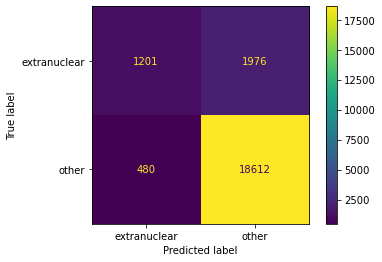

In [22]:
 # create random forest classifier INCLUDING random
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=4, bootstrap=True, oob_score=False)
rf_classifier.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["extranuclear"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 
    
#predict label
val_pred = rf_classifier.predict(adata_val_pattern.obsm["latent"])

confusion_matrix = metrics.confusion_matrix(adata_val_pattern.obs["extranuclear"], val_pred, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

RF excluding random

In [34]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_train_pattern.obs["extranuclear_no_random"] = np.where(adata_train_pattern.obs["pattern"] == "extranuclear", "extranuclear", "other")
adata_val_pattern = adata_val.copy()
adata_val_pattern = adata_val_pattern[adata_val_pattern.obs['pattern']!='random']
adata_val_pattern.obs["extranuclear_no_random"] = np.where(adata_val_pattern.obs["pattern"] == "extranuclear", "extranuclear", "other")


<ipython-input-34-ce1dcece7803>:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train_pattern.obs["extranuclear_no_random"] = np.where(adata_train_pattern.obs["pattern"] == "extranuclear", "extranuclear", "other")
<ipython-input-34-ce1dcece7803>:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_val_pattern.obs["extranuclear_no_random"] = np.where(adata_val_pattern.obs["pattern"] == "extranuclear", "extranuclear", "other")


In [31]:
adata_train_pattern.obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,blur_interval,...,cell-edge,extranuclear,intranuclear,pericellular,perinuclear,random,random_score,pattern_score,batch,extranuclear_no_random
663,cell-edge,pattern,81,90-100,27,blank,307,300+,1.5,NaN,...,0.992096,0.934968,5.487039e-15,1.322831e-10,0.000015,0.967630,0.392781,0.608507,0,other
664,cell-edge,pattern,81,90-100,27,blank,45,0-60,1.5,NaN,...,0.754152,0.798077,2.422030e-14,2.009141e-09,0.000235,0.627178,0.244180,0.757463,0,other
665,cell-edge,pattern,81,90-100,27,blank,90,60-120,1.5,NaN,...,0.999964,0.999141,8.410337e-18,1.347031e-07,0.000001,0.035344,0.089089,0.911159,0,other
897,cell-edge,pattern,24,20-30,27,blank,251,240-300,1.5,NaN,...,0.972466,0.127212,2.169975e-11,1.990620e-15,0.000403,1.000000,0.983680,0.016362,0,other
898,cell-edge,pattern,24,20-30,27,blank,65,60-120,1.5,NaN,...,0.004701,0.000760,6.626342e-10,3.418462e-15,0.003140,1.000000,0.945318,0.054801,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156222,perinuclear,pattern,27,20-30,108,blank,251,240-300,1.5,NaN,...,0.032426,0.723309,1.660171e-07,1.175373e-04,0.996019,0.033108,0.110164,0.890005,0,other
156223,perinuclear,pattern,27,20-30,108,blank,332,300+,1.5,NaN,...,0.502149,0.634688,1.423556e-07,4.383508e-05,0.488439,0.412596,0.169994,0.829664,0,other
156868,perinuclear,pattern,11,10-20,108,blank,100,60-120,1.5,NaN,...,0.013130,0.017682,1.378627e-05,2.662874e-08,0.974515,0.998928,0.599384,0.400611,0,other
156869,perinuclear,pattern,11,10-20,108,blank,168,120-180,1.5,NaN,...,0.059709,0.001133,3.874913e-04,1.750608e-06,0.153743,0.999459,0.706572,0.294269,0,other


In [32]:
 # create random forest classifier EXCLUDING random
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=4, bootstrap=True, oob_score=False)
rf_classifier.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["extranuclear_no_random"]) 
    
#predict label
val_pred = rf_classifier.predict(adata_val_pattern.obsm["latent"])

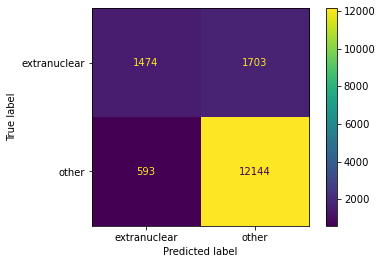

In [35]:
confusion_matrix = metrics.confusion_matrix(adata_val_pattern.obs["extranuclear_no_random"], val_pred, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

# K - nearest neighbours

Choice of k depends on the input data --> more outliers or noise performs better with a larger k (due to smoothing)

Recommended to have an odd number of k to avoid ties in classification. Use cross-validation to choose optimal k for the dataset.

Rule of thumb: choose a k close to the sqrt(datapoints), aka sqrt(176162)~419

Hyperparameter grid choice. Rule of thumb is that the sqrt(N) will work, and to use odd numbers. Therefore use sqrt as a center and 5 values above and below it. Given that 469 is a relatively large number, will first explore a larger space (i.e. 50 interval in between).

Based on [caching nearest neighbors - scikit-learn tutorial](https://scikit-learn.org/stable/auto_examples/neighbors/plot_caching_nearest_neighbors.html#sphx-glr-auto-examples-neighbors-plot-caching-nearest-neighbors-py) 

### Non-normalized KNN

Fitting 5 folds for each of 13 candidates, totalling 65 fits


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 1/5] END ........classifier__n_neighbors=69;, score=0.924 total time= 3.4min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 2/5] END ........classifier__n_neighbors=69;, score=0.928 total time= 3.3min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 3/5] END ........classifier__n_neighbors=69;, score=0.922 total time= 3.3min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 4/5] END ........classifier__n_neighbors=69;, score=0.921 total time= 3.3min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 5/5] END ........classifier__n_neighbors=69;, score=0.927 total time= 3.3min
[CV 1/5] END .......classifier__n_neighbors=119;, score=0.924 total time=  39.5s
[CV 2/5] END .......classifier__n_neighbors=119;, score=0.927 total time=  38.6s
[CV 3/5] END .......classifier__n_neighbors=119;, score=0.922 total time=  38.9s
[CV 4/5] END .......classifier__n_neighbors=119;, score=0.920 total time=  39.4s
[CV 5/5] END .......classifier__n_neighbors=119;, score=0.927 total time=  38.9s
[CV 1/5] END .......classifier__n_neighbors=169;, score=0.924 total time=  39.5s
[CV 2/5] END .......classifier__n_neighbors=169;, score=0.927 total time=  38.7s
[CV 3/5] END .......classifier__n_neighbors=169;, score=0.921 total time=  38.9s
[CV 4/5] END .......classifier__n_neighbors=169;, score=0.920 total time=  39.5s
[CV 5/5] END .......classifier__n_neighbors=169;, score=0.927 total time=  39.0s
[CV 1/5] END .......classifier__n_neighbors=219;, score=0.924 total time=  39.5s
[CV 2/5] END .......classifi

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


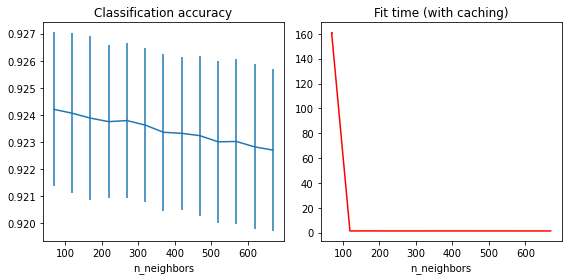

In [10]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

#from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

#X, y = load_digits(return_X_y=True)
n_neighbors_list = [69,119,169,219,269,319,369,419,469,519,569,619,669]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, verbose = 3)
    grid_model.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"])

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()

In [70]:
knn_nonnormalized = grid_model.cv_results_
knn_nonnormalized

{'mean_fit_time': array([160.32603569,   1.36809492,   1.39574623,   1.36634436,
          1.364711  ,   1.36581612,   1.37345982,   1.36978893,
          1.366711  ,   1.3668128 ,   1.36542826,   1.36534615,
          1.36573067]),
 'std_fit_time': array([0.85542984, 0.00948896, 0.01288597, 0.01100495, 0.01349895,
        0.01014704, 0.00980585, 0.00822732, 0.01277583, 0.00950512,
        0.01184004, 0.00794088, 0.01065287]),
 'mean_score_time': array([39.81324239, 37.69407601, 37.71695495, 37.73753662, 37.74229832,
        37.76169548, 37.77588997, 37.80055475, 37.80514007, 37.82576494,
        37.88281603, 37.9218977 , 37.94148393]),
 'std_score_time': array([0.66837186, 0.33251339, 0.33180792, 0.33658414, 0.33296387,
        0.33259267, 0.32914207, 0.33045184, 0.33654874, 0.33934595,
        0.31766483, 0.34116603, 0.33493058]),
 'param_classifier__n_neighbors': masked_array(data=[69, 119, 169, 219, 269, 319, 369, 419, 469, 519, 569,
                    619, 669],
              mas

#### Save and load the KNN object 
So that I don't have to rerun it later, and can just get the object to make vizualiations / multiplots. 

In [61]:
np.savez('knn_nonnormalized.npz', **knn_nonnormalized)

In [69]:
load_dict = dict(np.load('knn_nonnormalized.npz', allow_pickle=True))

Text(0.5, 1.0, 'Grid Search Results Non-Normalized Latent Space')

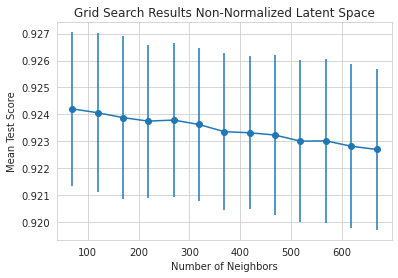

In [68]:
# Code to run the plot from the saved object. The x axis is a bit difficult to get cause it's a masked array, that's why it looks weird
fig, ax = plt.subplots()
ax.errorbar(load_dict.get("param_classifier__n_neighbors").compressed(), load_dict["mean_test_score"], yerr=load_dict['std_test_score'], fmt='-o')
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("Mean Test Score")
ax.set_title("Grid Search Results Non-Normalized Latent Space")

Text(0.5, 1.0, 'Grid Search Results')

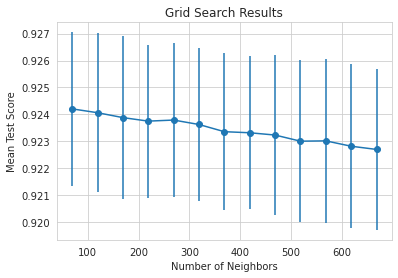

In [22]:
fig, ax = plt.subplots()
ax.errorbar(n_neighbors_list, grid_model.cv_results_["mean_test_score"], yerr=grid_model.cv_results_['std_test_score'], fmt='-o')
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("Mean Test Score")
ax.set_title("Grid Search Results Non-Normalized Latent Space")

### Normalized KNN

In [16]:
from scipy import stats
stats.normaltest(adata.obsm['latent'], axis=0)

NormaltestResult(statistic=array([ 2969.539  ,  1722.7858 , 17725.268  , 10980.781  ,   451.94302,
        6556.831  ,  4315.3906 ,  7899.7725 , 15158.62   , 10586.165  ,
       28376.576  ,  2222.5215 , 15285.311  , 25839.836  , 13798.633  ],
      dtype=float32), pvalue=array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.27477122e-99, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))

normalizing the dimensions and see if that influences the accuracy. Given that none of the latent dimensions are normally distributed, nor are they multivariate normally distributed, we will normalize the latent dimensions using min-max normalization rather than standardization (which assumes the data to be normally distributed)

In [71]:
adata_train2 = adata_train.copy()


In [72]:
adata_train_labels = adata_train.copy()
scaler = MinMaxScaler()
adata_train_labels.obsm['latent']=scaler.fit_transform(adata_train_labels.obsm['latent'])
adata_train_labels.obsm['latent']
pattern_mapping = {'pattern': 1, 'random': 0}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 1/5] END ........classifier__n_neighbors=69;, score=0.947 total time= 4.4min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 2/5] END ........classifier__n_neighbors=69;, score=0.949 total time= 4.5min
[CV 3/5] END ........classifier__n_neighbors=69;, score=0.945 total time= 4.4min
[CV 4/5] END ........classifier__n_neighbors=69;, score=0.945 total time= 4.4min
[CV 5/5] END ........classifier__n_neighbors=69;, score=0.949 total time= 4.5min
[CV 1/5] END .......classifier__n_neighbors=119;, score=0.947 total time=  52.2s
[CV 2/5] END .......classifier__n_neighbors=119;, score=0.949 total time=  50.1s
[CV 3/5] END .......classifier__n_neighbors=119;, score=0.945 total time=  49.6s
[CV 4/5] END .......classifier__n_neighbors=119;, score=0.944 total time=  51.1s
[CV 5/5] END .......classifier__n_neighbors=119;, score=0.949 total time=  51.0s
[CV 1/5] END .......classifier__n_neighbors=169;, score=0.946 total time=  50.8s
[CV 2/5] END .......classifier__n_neighbors=169;, score=0.949 total time=  50.9s
[CV 3/5] END .......classifier__n_neighbors=169;, score=0.945 total time=  50.2s
[CV 4/5] END .......classifi

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.63s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


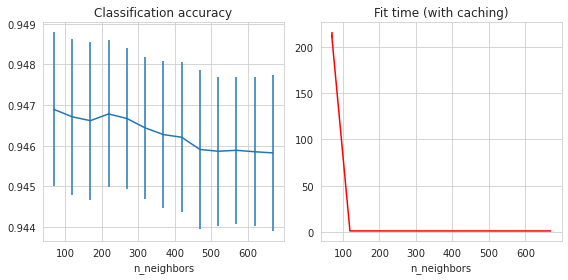

In [73]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

#from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]
n_neighbors_list = [69,119,169,219,269,319,369,419,469,519,569,619,669]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, verbose = 3, scoring='f1', error_score='raise')
    grid_model.fit(latent, labels)

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()

In [74]:
knn_normalized = grid_model.cv_results_
np.savez('knn_normalized.npz', **knn_normalized)

In [75]:
print(grid_model.best_params_)
grid_model.best_score_

{'classifier__n_neighbors': 69}


0.9468950007408262

## Multi-class KNN

Hyperparameter grid around sqrt(157654)~355

In [10]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_val_pattern = adata_val.copy()
adata_val_pattern = adata_val_pattern[adata_val_pattern.obs['pattern']!='random']
#pattern_mapping = {'pattern': 1, 'random': 0}
#adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [11]:
adata_train_pattern.obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,blur_interval,...,pattern_classified,cell-edge,extranuclear,intranuclear,pericellular,perinuclear,random,random_score,pattern_score,batch
663,cell-edge,pattern,81,90-100,27,blank,307,300+,1.5,NaN,...,cell-edge,0.992096,0.934968,5.487039e-15,1.322831e-10,0.000015,0.967630,0.392781,0.608507,0
664,cell-edge,pattern,81,90-100,27,blank,45,0-60,1.5,NaN,...,extranuclear,0.754152,0.798077,2.422030e-14,2.009141e-09,0.000235,0.627178,0.244180,0.757463,0
665,cell-edge,pattern,81,90-100,27,blank,90,60-120,1.5,NaN,...,cell-edge,0.999964,0.999141,8.410337e-18,1.347031e-07,0.000001,0.035344,0.089089,0.911159,0
897,cell-edge,pattern,24,20-30,27,blank,251,240-300,1.5,NaN,...,random,0.972466,0.127212,2.169975e-11,1.990620e-15,0.000403,1.000000,0.983680,0.016362,0
898,cell-edge,pattern,24,20-30,27,blank,65,60-120,1.5,NaN,...,random,0.004701,0.000760,6.626342e-10,3.418462e-15,0.003140,1.000000,0.945318,0.054801,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156222,perinuclear,pattern,27,20-30,108,blank,251,240-300,1.5,NaN,...,perinuclear,0.032426,0.723309,1.660171e-07,1.175373e-04,0.996019,0.033108,0.110164,0.890005,0
156223,perinuclear,pattern,27,20-30,108,blank,332,300+,1.5,NaN,...,extranuclear,0.502149,0.634688,1.423556e-07,4.383508e-05,0.488439,0.412596,0.169994,0.829664,0
156868,perinuclear,pattern,11,10-20,108,blank,100,60-120,1.5,NaN,...,random,0.013130,0.017682,1.378627e-05,2.662874e-08,0.974515,0.998928,0.599384,0.400611,0
156869,perinuclear,pattern,11,10-20,108,blank,168,120-180,1.5,NaN,...,random,0.059709,0.001133,3.874913e-04,1.750608e-06,0.153743,0.999459,0.706572,0.294269,0


In [16]:
adata_train_pattern.obsm['latent']

ArrayView([[-0.3208191 ,  2.8225806 , -1.3590801 , ..., -5.384647  ,
            -8.265151  ,  5.773748  ],
           [-0.40570036,  2.9171438 , -0.9277612 , ..., -5.3958044 ,
            -7.8791065 ,  5.4216666 ],
           [-0.97488296,  3.6805127 , -1.9317566 , ..., -5.5002418 ,
            -7.7567444 ,  5.3031464 ],
           ...,
           [ 2.6768274 ,  2.9809794 , -2.6266003 , ..., -4.2222443 ,
            -7.9422026 ,  7.013573  ],
           [ 1.7666696 ,  2.5898604 , -1.8280711 , ..., -2.933899  ,
            -6.9415245 ,  6.9567447 ],
           [ 1.7096524 ,  2.0780938 , -1.8532205 , ..., -3.107962  ,
            -6.902675  ,  6.38632   ]], dtype=float32)

In [24]:
np.sqrt(125852)

354.7562543493772

We use average='macro', which calculate the F1 score over all the classes, which we do because all patterns have an equal amount of observations, so there is no class imbalance.

In [17]:
scaler = MinMaxScaler()
adata_train_pattern.obsm['latent']=scaler.fit_transform(adata_train_pattern.obsm['latent'])
adata_train_pattern.obsm['latent']

array([[0.5566338 , 0.37366953, 0.31004786, ..., 0.7680447 , 0.387528  ,
        0.34089357],
       [0.5494416 , 0.38041553, 0.3482966 , ..., 0.7675096 , 0.41180426,
        0.30852818],
       [0.5012134 , 0.43487304, 0.2592637 , ..., 0.7625008 , 0.41949895,
        0.2976331 ],
       ...,
       [0.8106315 , 0.38496947, 0.19764595, ..., 0.8237932 , 0.4078365 ,
        0.45486546],
       [0.7335117 , 0.35706764, 0.26845837, ..., 0.88558185, 0.47076374,
        0.44964147],
       [0.7286805 , 0.32055902, 0.2662282 , ..., 0.87723386, 0.47320676,
        0.39720476]], dtype=float32)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 1/5] END ........classifier__n_neighbors=55;, score=0.843 total time= 1.9min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 2/5] END ........classifier__n_neighbors=55;, score=0.833 total time= 1.9min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 3/5] END ........classifier__n_neighbors=55;, score=0.844 total time= 1.9min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 4/5] END ........classifier__n_neighbors=55;, score=0.828 total time= 1.9min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 5/5] END ........classifier__n_neighbors=55;, score=0.846 total time= 2.0min
[CV 1/5] END .......classifier__n_neighbors=105;, score=0.839 total time=  24.1s
[CV 2/5] END .......classifier__n_neighbors=105;, score=0.830 total time=  23.6s
[CV 3/5] END .......classifier__n_neighbors=105;, score=0.841 total time=  23.6s
[CV 4/5] END .......classifier__n_neighbors=105;, score=0.824 total time=  24.0s
[CV 5/5] END .......classifier__n_neighbors=105;, score=0.844 total time=  24.6s
[CV 1/5] END .......classifier__n_neighbors=155;, score=0.837 total time=  24.2s
[CV 2/5] END .......classifier__n_neighbors=155;, score=0.827 total time=  23.6s
[CV 3/5] END .......classifier__n_neighbors=155;, score=0.839 total time=  23.7s
[CV 4/5] END .......classifier__n_neighbors=155;, score=0.823 total time=  24.0s
[CV 5/5] END .......classifier__n_neighbors=155;, score=0.842 total time=  24.4s
[CV 1/5] END .......classifier__n_neighbors=205;, score=0.836 total time=  24.2s
[CV 2/5] END .......classifi

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


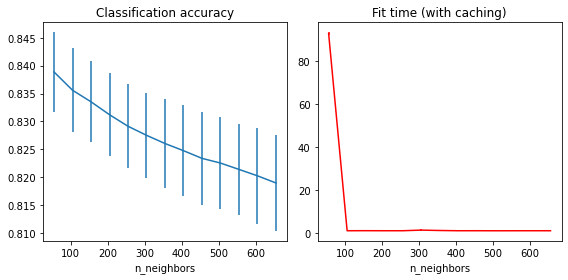

In [18]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

#from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

latent = adata_train_pattern.obsm["latent"]
labels = adata_train_pattern.obs["pattern"]
n_neighbors_list = [55,105,155,205,255,305,355,405,455,505,555,605,655]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, verbose = 3, scoring='f1_macro', error_score='raise')
    grid_model.fit(latent, labels)

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()

In [20]:
knn_pattern = grid_model.cv_results_
np.savez('knn_patterns.npz', **knn_pattern)